# Aprendizaje Multietiqueta de Patrones Geométricos en Objetos de Herencia Cultural
# Testing multilabel algorithms
## Seminario de Tesis II, Primavera 2022
### Master of Data Science. Universidad de Chile.
#### Prof. guía: Benjamín Bustos - Prof. coguía: Iván Sipirán
#### Autor: Matías Vergara

### References:

Zhang, M. L., Li, Y. K., Liu, X. Y., & Geng, X. (2018). Binary relevance for multi-label learning: an overview. Frontiers of Computer Science, 12(2), 191–202.
https://doi.org/10.1007/s11704-017-7031-7

Kariuki C. Multi-Label Classification with Scikit-MultiLearn. 
https://www.section.io/engineering-education/multi-label-classification-with-scikit-multilearn/

## Mounting Google Drive



In [6]:
# Mounting google Drive
try:
    from google.colab import drive
    drive.mount('/content/drive')
    folder_path = 'drive/MyDrive/TesisMV/'
except:
    folder_path = '../'

In [7]:
import os
os.listdir(folder_path)

['.git',
 '.gitignore',
 '.idea',
 'actas',
 'entregables',
 'features',
 'graficos',
 'labels',
 'models',
 'notebooks',
 'patterns',
 'presentaciones',
 'README.md',
 'requirements.txt',
 'tablas']

## Dataset and model selection

In [8]:
#modify only this cell
USE_RN50 = False
SUBCHAPTERS = False
DS_FLAGS = ['base']
              # 'ref': [invertX, invertY],
              # 'rot': [rotate90, rotate180, rotate270],
              # 'crop': [crop] * CROP_TIMES,
              # 'blur': [blur],
              # 'emboss': [emboss],
              # 'randaug': [randaug],
              # 'rain': [rain],
              # 'elastic': [elastic]
CROP_TIMES = 2
RANDOM_TIMES = 2
ELASTIC_TIMES = 3

In [9]:
# This cells builds the data_flags variable, that will be used
# to map the requested data treatment to folders
MAP_TIMES = {'crop': CROP_TIMES,
         'randaug': RANDOM_TIMES,
         'elastic': ELASTIC_TIMES,
}

DS_FLAGS = sorted(DS_FLAGS)
data_flags = '_'.join(DS_FLAGS) if len(DS_FLAGS) > 0 else 'base'
MULTIPLE_TRANSF = ['crop', 'randaug', 'elastic']
COPY_FLAGS = DS_FLAGS.copy()

for t in MULTIPLE_TRANSF:
    if t in DS_FLAGS:
        COPY_FLAGS.remove(t)
        COPY_FLAGS.append(t + str(MAP_TIMES[t]))
        data_flags = '_'.join(COPY_FLAGS)

subchapter_str = 'subchapters/' if SUBCHAPTERS else ''
patterns_path = folder_path + 'patterns/' + subchapter_str + data_flags + "/"
labels_path = folder_path + 'labels/' +  subchapter_str + data_flags + "/"
data_flags = f'resnet50_{data_flags}' if USE_RN50 else f'resnet18_{data_flags}'
features_path = folder_path + "features/" + subchapter_str + data_flags + '/'

#rn = 18
#ep = 65
#labels_path = folder_path + 'labels/' +  subchapter_str + data_flags + "/"
#data_flags = f'resnet50_{data_flags}_e{ep}' if USE_RN50 else f'resnet18_{data_flags}_e{ep}'
#features_path = folder_path + f"features/resnet{rn}_blur_each5/resnet{rn}_blur_e{ep}/"

print(features_path)
print(labels_path)
if not (os.path.isdir(features_path) and os.path.isdir(labels_path)):
    raise FileNotFoundError("No existen directorios de datos para el conjunto de flags seleccionado. Verifique que el dataset exista y, de lo contrario, llame a Split and Augmentation {}".format(
        (os.path.isdir(features_path), os.path.isdir(labels_path))))
print("Features set encontrado en {}".format(features_path))
print("Labels set encontrado en {}".format(labels_path))

../features/resnet18_base/
../labels/base/
Features set encontrado en ../features/resnet18_base/
Labels set encontrado en ../labels/base/


In [10]:
train_filename = "augmented_train_df.json"
val_filename = "val_df.json"
test_filename = "test_df.json"

# Imports

In [11]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# Data treatment
import pandas as pd
import numpy as np
from scipy import sparse
from sklearn.model_selection import train_test_split

# Base classifiers
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import accuracy_score,hamming_loss
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import tree

# Multilabel classifiers - Problem Transformation
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import LabelPowerset
from skmultilearn.ensemble import RakelD

# Multilabel classifiers - Algorithm Adaptation
from skmultilearn.adapt import BRkNNaClassifier
from skmultilearn.adapt import MLkNN
from skmultilearn.adapt import MLTSVM

# Metrics
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Data processing

In [12]:
features_path + test_filename

'../features/resnet18_base/test_df.json'

In [13]:
features_train = pd.read_json(features_path + train_filename, orient='index').sort_index()
features_val = pd.read_json(features_path + val_filename, orient='index').sort_index()
features_test = pd.read_json(features_path + test_filename, orient='index').sort_index()

In [14]:
features_train

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
10b,0.362146,0.464590,0.127147,0.513911,0.456054,0.456919,0.613942,0.897593,0.727839,0.993983,...,0.685357,0.484074,0.518595,1.072349,2.006864,1.752992,0.477887,1.221545,1.052200,0.479289
10c,0.474254,1.758468,0.570486,0.409202,0.051586,0.105452,0.403314,0.476372,0.848582,0.205794,...,0.086466,1.045404,0.341057,0.478624,1.017079,0.487478,0.423797,1.231365,0.396027,0.057165
10e,0.244714,0.577980,0.151823,0.289470,0.130480,0.313273,0.260450,0.380469,0.730706,0.422372,...,0.469919,0.593789,0.186124,0.576883,1.709014,0.757188,0.458053,1.712341,0.606818,0.144883
11a,0.293450,0.619049,0.095415,0.067594,0.027575,0.008564,0.003278,0.006090,1.565796,0.042254,...,0.016275,0.367695,0.000443,0.026875,0.648703,0.051497,0.684499,1.231126,0.011604,0.000000
11b,1.993804,1.640780,1.178390,0.140833,0.391556,0.061228,0.178909,0.000000,2.201008,0.000000,...,0.028581,0.457537,0.022230,0.000000,0.014756,0.000895,2.500922,0.248379,0.015935,0.034870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96i,1.219496,1.172501,1.439793,0.180357,0.460851,0.231148,1.772079,2.312201,0.359803,1.313780,...,0.259646,1.262572,1.754678,0.252364,1.004960,0.327329,0.155870,0.716203,0.145088,0.615618
9a,0.152805,0.218222,0.045043,0.057803,0.096010,1.143477,1.549839,2.302843,0.423475,2.282072,...,0.081713,0.409658,0.563725,1.192688,2.347401,0.432017,0.048915,0.552882,2.373051,2.593569
9b,0.115341,0.540795,0.048241,0.585017,0.315587,0.945200,1.351170,2.774725,0.373930,2.246647,...,0.409086,0.705647,1.119104,1.559311,2.738190,1.006094,0.023455,1.138020,2.416279,2.388109
9d,0.020692,0.064446,0.004796,0.037519,0.347206,2.454232,2.441526,4.735280,0.180497,4.700363,...,0.172130,0.211454,1.714322,2.062657,3.856583,0.358296,0.005878,0.656203,4.139779,5.181756


In [15]:
features_val

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
11c,2.275187,2.306436,1.497855,0.272794,0.173614,0.029822,0.786899,0.016024,1.781992,0.000000,...,0.082154,0.483801,0.116884,0.007031,0.046339,0.040790,2.441685,0.152227,0.100701,0.071847
12d,1.504374,1.664972,0.724834,0.216324,0.191819,0.045470,0.258362,0.005485,1.445316,0.000000,...,0.028517,0.700710,0.004696,0.005331,0.094490,0.020422,1.538262,0.462807,0.023431,0.000572
13h,1.902758,1.247735,0.951118,0.045546,0.405237,0.045735,0.230148,0.046895,1.569113,0.002871,...,0.069816,0.538065,0.031151,0.004312,0.114544,0.008827,1.917671,0.364544,0.009181,0.036641
14a,0.217449,0.966793,0.385966,0.385033,0.012851,0.003168,0.008533,0.167349,1.020717,0.119414,...,0.000000,0.810362,0.319307,0.176306,1.049837,0.556223,0.208913,1.501853,0.138571,0.000000
17g,0.279239,0.814089,0.281765,0.108073,0.055922,0.125924,0.630793,0.725520,0.532767,0.523044,...,0.271441,0.948651,0.388443,0.415188,1.384727,0.753298,0.056655,1.080516,0.693169,0.153720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95d,0.593016,0.555426,0.802065,0.086066,0.630167,0.502185,1.588610,2.020831,0.383938,1.362503,...,0.601381,1.319863,1.444178,0.325408,1.398862,0.346076,0.056853,0.767345,0.252263,0.841485
95e,1.223325,0.867830,1.330138,0.019909,0.937184,0.675793,3.024865,3.361417,0.326847,2.265049,...,0.824268,1.228300,2.281181,0.501471,0.945814,0.022220,0.253525,0.344478,0.346123,1.462925
95k,1.749108,1.211776,2.177898,0.106079,0.529525,0.295415,1.889722,2.695512,0.372247,1.376209,...,0.377079,1.606109,2.209428,0.121024,0.695410,0.166861,0.300892,0.513554,0.051362,0.606356
96a,0.080941,0.376536,0.177453,0.050869,0.127184,0.151660,1.240737,1.800235,0.162123,1.296215,...,0.318814,1.286526,0.754040,0.439462,2.203444,0.865236,0.002921,1.046490,0.559765,0.721506


In [16]:
features_test

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
10a,0.043922,0.438790,0.019845,0.413530,1.033888,1.425813,2.464794,2.822518,0.327268,2.642690,...,0.986162,0.511597,1.491543,1.570246,1.970436,0.596666,0.013391,0.688872,1.930300,2.450351
10d,1.589746,2.419186,1.238558,0.502969,0.177709,0.095080,0.895335,0.366388,1.248019,0.112939,...,0.116706,0.871342,0.422499,0.181066,0.322997,0.081184,1.647915,0.687288,0.200599,0.083305
11k,0.102749,0.537323,0.005930,0.229182,0.029631,0.051531,0.215764,0.333154,0.571127,0.300135,...,0.220662,0.589854,0.071657,0.772262,2.141778,1.487517,0.082396,1.918550,1.108924,0.011656
12c,1.555241,3.085774,1.036549,0.121381,0.006848,0.000000,0.667729,0.255454,1.389393,0.000000,...,0.000000,1.271174,0.073674,0.070102,0.040569,0.000000,1.040871,0.572813,0.067655,0.000000
13b,0.054596,0.961921,0.005172,0.164097,0.000000,0.004722,0.159693,0.354636,0.752471,0.284906,...,0.086444,0.702418,0.067545,0.609984,2.001049,1.166788,0.070118,2.045304,0.894990,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94b,0.037165,0.320686,0.016477,0.341343,0.183347,0.460720,0.543568,1.344331,0.467561,1.105291,...,0.505929,0.719686,0.514762,0.890770,2.208013,1.220502,0.034576,1.544689,1.782199,1.038253
95h,1.390886,0.709396,1.206319,0.012485,0.542104,0.357813,3.210945,3.415834,0.188296,2.201178,...,0.688189,1.365511,1.973725,0.436885,0.848364,0.105438,0.121058,0.255382,0.361521,1.424006
95i,1.011852,0.831163,1.210996,0.044076,0.328944,0.154378,1.714137,2.140866,0.300445,1.232799,...,0.198398,1.656799,1.454919,0.205952,1.358049,0.170531,0.082664,0.721915,0.087386,0.602120
95m,0.330874,1.042076,0.552560,0.194703,0.072272,0.098493,1.199120,1.807134,0.287773,0.946855,...,0.223451,1.513646,0.949666,0.598369,2.023210,0.933003,0.057617,1.188486,0.473440,0.348476


In [17]:
features_test_val = pd.DataFrame.append(features_test, features_val )

In [18]:
labels_train = pd.read_json(labels_path + train_filename, orient='index').sort_index()
labels_val = pd.read_json(labels_path + val_filename, orient='index').sort_index()
labels_test = pd.read_json(labels_path + test_filename, orient='index').sort_index()

In [19]:
labels_train

,pendent,teardrop,horizontal,panel,group,vertical,bar,floating,enclosing,shorter,...,light,body,bird,striped,worm,angular,raised,head,bird-seed,long
10a,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10c,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10d,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
10e,0,0,1,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11a,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96h,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9a,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9b,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9c,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
labels_val

,pendent,teardrop,horizontal,panel,group,vertical,bar,floating,enclosing,shorter,...,light,body,bird,striped,worm,angular,raised,head,bird-seed,long
12e,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12f,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13c,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13d,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
16k,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93g,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
94a,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
94c,0,0,1,1,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
96a,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
labels_test

,pendent,teardrop,horizontal,panel,group,vertical,bar,floating,enclosing,shorter,...,light,body,bird,striped,worm,angular,raised,head,bird-seed,long
10b,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
12b,0,0,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
12d,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13f,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13h,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95i,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
95k,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96b,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
96i,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
labels_test_val = pd.DataFrame.append(labels_test, labels_val)
labels_test_val

,pendent,teardrop,horizontal,panel,group,vertical,bar,floating,enclosing,shorter,...,light,body,bird,striped,worm,angular,raised,head,bird-seed,long
10b,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
12b,0,0,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
12d,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13f,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13h,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93g,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
94a,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
94c,0,0,1,1,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
96a,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
def filter_labels(labels_df, freq, number_labels = None):
  """Filters a label dataframe based on labels frequency (number of events)

    Parameters:
    labels_df (DataFrame): dataframe of labels 
    freq (int): threshold frequency. Labels with a lower value will be filtered. 

    Returns:
    DataFrame: filtered labels dataframe

  """
  top_labels = None

  if not number_labels:
    filtered_df = labels_df.loc[:, labels_df.sum(axis=0) > freq]
    top_labels = filtered_df.sum().sort_values(ascending=False)
    return top_labels, 0

  if number_labels:
      filtered_labels = 0
      pivot = freq
      while filtered_labels != number_labels:
              filtered_df = labels_df.loc[:, labels_df.sum(axis=0) > pivot]
              top_labels = filtered_df.sum().sort_values(ascending=False)
              if len(top_labels.values) > number_labels:
                  pivot += 1
              elif len(top_labels.values) < number_labels:
                  pivot -= 1
              else:
                  print("Aplicando threshold {} para trabajar con {} labels".format(pivot, len(top_labels.values)))
                  return top_labels, pivot

def filter_dfs(df, top_labels_df):
  df = df[df.columns.intersection(top_labels_df.index)]
  return df

def combine_dfs(labels_df, top_labels_df, features_df):
  """Combine labels dataframe with features dataframe based on index (patterns names)
     keeping only the most frequent labels.

    Parameters:
    labels_df (DataFrame): dataframe of labels, with patterns name as index
    top_labels_df (DataFrame): a 1D dataframe with the name of the most freq. labels, as 
    the outcome of filter_labels() function 
    features_df (DataFrame): dataframe of features, with patterns name as index 

    Returns:
    DataFrame: combined labels + features dataframe, merged on index

  """
  assert len(labels_df) == len(features_df)
  labels_df = labels_df[labels_df.columns.intersection(top_labels_df.index)]
  final_df = pd.merge(labels_df,       
                      features_df,  
                      left_index=True, right_index=True)
  return final_df

def split_data(final_df, top_labels_df, test_size):
  """Splits the data in train and test. 
    
    Parameters:
    final_df (DataFrame): outcome of combine_dfs.
    top_labels_df (DataFrame): dataframe of most freq. labels. Necessary to 
    know at which column the labels (Y) ends and the features (X) starts  
    freq (int): threshold frequency. Labels with a lower value will be filtered. 
    test_size (float): proportion test/(test+train).

    Returns:
    (np.array, np.array, np.array, np.array): X train, X test, Y train, Y test

  """
  X = np.array(final_df.iloc[:, len(final_df):], dtype=float)
  Y = np.array(final_df.iloc[:, 0:len(final_df)], dtype=float)
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size,random_state=42)
  return X_train, X_test, Y_train, Y_test

In [24]:
top_labels_df, pivot = filter_labels(labels_train, 25, 25) # for example
top_labels_df

Aplicando threshold 25 para trabajar con 25 labels


panel            317
horizontal       254
vertical         121
hatched          120
ornament         114
lozenge           99
metopal           93
filling           84
triangle          69
double            69
cross-hatched     65
meander           57
chain             53
bar               48
outline           38
line              37
single            36
hook              36
dotted            36
zigzag            34
solid             31
turning           30
left              28
dot               27
right             27
dtype: int64

# Data exploration

In [25]:
def get_unique_combinations(labels_df):
  """Returns the number of different combinations of labels in labels_df.

    Parameters:
    labels_df (DataFrame): dataframe of labels 

    Returns:
    int: number of unique labels combinations in labels_df
  """
  unique_combinations = len(labels_df.drop_duplicates())
  print("Number of unique labels combinations: " + str(unique_combinations))
  return unique_combinations

def get_label_metrics(labels_df):
  """Returns label cardinality and label density of a multilabel dataset.
     Label cardinality: average number of labels per entry 
     Label density: fraction of assigned labels over total num of labels,
                    averaged per entry
    Parameters:
    labels_df (DataFrame): dataframe of labels 
    freq (int): threshold frequency. Labels with a lower value will be filtered. 

    Returns:
    DataFrame: filtered labels dataframe

  """
  sum_labels = labels_df.sum(axis=1)
  total_labels = labels_df.shape[0]
  label_cardinality = 0
  for label in sum_labels:
    label_cardinality += label/total_labels
  label_density = label_cardinality/total_labels
  print("Label cardinality: {}".format(label_cardinality))
  print("Label density: {}".format(label_density))
  return(label_cardinality, label_density)

print("Exploring train set")
combinations = get_unique_combinations(labels_train)
metrics = get_label_metrics(labels_train)

Exploring train set
Number of unique labels combinations: 422
Label cardinality: 5.392988929889309
Label density: 0.009950164077286548


# Functions to run experiments and visualizations

In [26]:
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    '''
    Compute the Hamming score (a.k.a. label-based accuracy) for the multi-label case
    http://stackoverflow.com/q/32239577/395857
    '''
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        #print('\nset_true: {0}'.format(set_true))
        #print('set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        #print('tmp_a: {0}'.format(tmp_a))
        acc_list.append(tmp_a)
    return np.mean(acc_list)

In [27]:
def build_model(mlb_estimator, xtrain, ytrain, xtest, ytest, model=None):
    """Builds a multilabel estimator and runs it over a given train and test data,
       with an optional base classifier model.

    Parameters:
    mlb_estimator (mlb classifier): a PROBLEM_TRANSFORMATION or ALGORITHM_ADAPTATION 
                                    method from sklearn-multilabel
    xtrain, ytrain, xtest, ytest (np arrays): train and test data
    model (Base Estimator): optional, ignored if mlb_estimator is part of 
                            ALGORITHM_ADAPTATION methods. Base classifier to be 
                            used with the PROBLEM_TRANSFORMATION methods.

    Returns:
    (dict, np.array): dict with metrics (exact match, hamming loss and score) 
                      and array of predictions.
    """
    xtrain = sparse.csr_matrix(xtrain)
    ytrain = sparse.csr_matrix(ytrain)
    xtest = sparse.csr_matrix(xtest)
    ytest = sparse.csr_matrix(ytest)
    if model:
      clf = mlb_estimator(model)
    else:
      clf = mlb_estimator
    clf.fit(xtrain, ytrain)
    clf_predictions = clf.predict(xtest)
    clf_predictions = sparse.csr_matrix(clf_predictions)
    exact_match = accuracy_score(ytest,clf_predictions)
    ham_loss = hamming_loss(ytest,clf_predictions)
    ham_score = hamming_score(ytest.toarray(), clf_predictions.toarray())
    result = {"exact_match":exact_match,"hamming_loss": ham_loss, "hamming_score":ham_score}
    return result, clf_predictions

In [28]:
# Plotting linemarks
ALREADY_RUN = False 

# This code has to be executed only once in order to have the same linemarks in 
# each figure
if not ALREADY_RUN:
  import random
  linemark = []
  MARKERS = ['.','+','v','x','*']
  LINE_STYLES = ['-','--','-.',':']

  for i in range(0, 20): 
    linestyle = LINE_STYLES[random.randint(0, len(LINE_STYLES)-1)]
    marker = MARKERS[random.randint(0, len(MARKERS)-1)]
    linemark.append (linestyle + marker)
  
  ALREADY_RUN = True

In [29]:
  def plot_results(x, acc = [], loss = [], score=[], label=[], title = "",
                 xlabel = "", ylabel = "", plot_emr=False, plot_hl=False, plot_hs=True):
    """plots accuracy, hamming loss and hamming score of multiple classifiers.
    
    Returns:
    DataFrame: filtered labels dataframe

    """
    assert len(acc) == len(loss) == len(label)
    if plot_emr:
        f_acc = plt.figure(1)
        f_acc.set_figheight(9)
        f_acc.set_figwidth(7)
        ax1 = f_acc.add_subplot(111)
        ax1.set_title(title + "\n Exact Match Ratio")
        ax1.set_xlabel(xlabel)
        ax1.set_ylabel(ylabel)
        ax1.set_ylim(0, 1)
        for i in range(0, len(acc)):
          ax1.plot(x, acc[i],  linemark[i], label=label[i])
        ax1.legend()
        f_acc.show()
    if plot_hl:
        f_loss = plt.figure(2)
        f_loss.set_figheight(9)
        f_loss.set_figwidth(7)
        ax2 = f_loss.add_subplot(111)
        ax2.set_title(title  + "\n Hamming Loss")
        ax2.set_xlabel(xlabel)
        ax2.set_ylabel(ylabel)
        for i in range(0, len(loss)):
          ax2.plot(x, loss[i], linemark[i], label=label[i])
        ax2.legend()
        f_loss.show()

    if plot_hs:
        f_score = plt.figure(3)
        f_score.set_figheight(9)
        f_score.set_figwidth(7)
        ax3 = f_score.add_subplot(111)
        ax3.set_title(title  + "\n Hamming Score")
        ax3.set_xlabel(xlabel)
        ax3.set_ylabel(ylabel)
        ax3.set_ylim(0, 1)
        #ax3.set_xlim(0, 100)
        for i in range(0, len(score)):
          ax3.plot(x, score[i], linemark[i], label=label[i])
        ax3.legend()
        f_score.show()

In [30]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):
    """
    Prints confusion matrix for multilabel classification.
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title(class_label)

def plot_multiple_matrix(cfs_matrix, present_labels, nrows=5, ncols=5, figsize=(6,10), filename="results"):
  """
  Plots multiple confusion matrix

  Parameters:
  cfs_matrix (2D array): an array containing the multiple confusion matrix as
                         outcome of multilabel_confusion_matrix()
  present_labels (1D array): array of strings with name of labels, in the same
                             order as they are in cfs_matrix
  nrows, ncols, figsize: number of rows, columns and size of the plot
  
  """
  fig, ax = plt.subplots(nrows, ncols, figsize=figsize)

  for axes, cfs_vals, label in zip(ax.flatten(), cfs_matrix, present_labels):
      print_confusion_matrix(cfs_vals, axes, label, ["N", "Y"])

  fig.tight_layout()
  plt.show()
  plt.savefig(filename + ".png")

# Benchmark


In [31]:
data_flags

'resnet18_base'

In [32]:
#MIN_FREQS = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24,
#            26, 30, 34, 38, 40, 50, 60, 80, 100]
MIN_FREQS = [5, 10, 20, 30, 40, 50, 60, 70, 80, 100, 150, 200]
#labels_25, pivot = filter_labels(labels_train, 25, 25)
#freq_25 = labels_25.shape[0]
#MIN_FREQS = [int(pivot * 0.7), pivot, int(pivot * 1.3)]
#MIN_FREQS = [pivot]

TRANSF_METHODS = {"BR": BinaryRelevance, "LP": LabelPowerset,
                  "CC": ClassifierChain, "RakelD": RakelD}
mlknn = MLkNN(k=1, s=1)
mltsvm = MLTSVM(c_k=4)
brknna = BRkNNaClassifier(k=1)
ADAPT_METHODS = {"MLkNN": mlknn, "MLTSVM": mltsvm, "BRkNN": brknna}
BASE_CLASSIFIERS = {"LR": LogisticRegression(solver='lbfgs'),
                    "SVC": svm.SVC(), "DT": tree.DecisionTreeClassifier(), "GNB": GaussianNB()}
exp_exact_match = {}
exp_hscore = {}
exp_hloss = {}

for meth_name in TRANSF_METHODS.keys():
  for base_name in BASE_CLASSIFIERS.keys():
    exp_exact_match[meth_name + "_" + base_name] = []
    exp_hscore[meth_name + "_" + base_name] = []
    exp_hloss [meth_name + "_" + base_name] = []

for meth_name in ADAPT_METHODS.keys():
  exp_exact_match[meth_name] = []
  exp_hscore[meth_name] = []
  exp_hloss [meth_name] = []

for i in MIN_FREQS:
  print("Starting with i={}".format(i))
  # Dataset creation
  top_labels_i, _ = filter_labels(labels_train, i)
  X_train = features_train
  X_test = features_test_val   # labels_test_val since val examples are unrecognized to multilabel algorithms
  Y_train = filter_dfs(labels_train, top_labels_i) # reduce labels to most freq
  Y_test = filter_dfs(labels_test_val, top_labels_i) # in both train and test

  for meth_name, method in ADAPT_METHODS.items():
    output_i, predictions_i = build_model(method, X_train, Y_train, X_test, Y_test)
    exp_exact_match[meth_name].append(output_i['exact_match'])
    exp_hscore[meth_name].append(output_i['hamming_score'])
    exp_hloss[meth_name].append(output_i['hamming_loss'])

  # Linear regression and SVC will raise error if Y_train is composed by only one class
  for meth_name, method in TRANSF_METHODS.items():
    for base_name, classifier in BASE_CLASSIFIERS.items():
      output_i, _ = build_model(method, X_train, Y_train, X_test, Y_test, model=classifier)
      exp_exact_match[meth_name + "_" + base_name].append(output_i['exact_match'])
      exp_hscore[meth_name + "_" + base_name].append(output_i['hamming_score'])
      exp_hloss[meth_name + "_" + base_name].append(output_i['hamming_loss'])


Starting with i=5


KeyboardInterrupt: 

In [ ]:
plot_results(MIN_FREQS,
             acc = list(exp_exact_match.values()),
             loss = list(exp_hloss.values()),
             score = list(exp_hscore.values()),
             label= list(exp_exact_match.keys()),
             title = data_flags,
            xlabel = "Min label frequency", ylabel = "Score")

# Best model at a given threshold

In [56]:
for m, hl in zip(exp_exact_match.keys(), exp_hscore.values()):
    print(m, hl)

BR_LR [0.12107244607244608, 0.15894383394383393, 0.1653846153846154, 0.1794871794871795, 0.200997150997151, 0.20405982905982906, 0.2108262108262108, 0.22542735042735043, 0.22542735042735043, 0.25356125356125353, 0.41239316239316237, 0.41239316239316237]
BR_SVC [0.11037851037851037, 0.14522792022792022, 0.1586182336182336, 0.16851851851851854, 0.17998575498575498, 0.18198005698005695, 0.1883903133903134, 0.20263532763532763, 0.20263532763532763, 0.21296296296296297, 0.2564102564102564, 0.2564102564102564]
BR_DT [0.09772176620711985, 0.10791721615628101, 0.11890927385836887, 0.13757985841319173, 0.1526217609550943, 0.14826176909510244, 0.16974460724460722, 0.175976800976801, 0.20684778184778185, 0.22799145299145296, 0.3717948717948718, 0.3803418803418803]
BR_GNB [0.05217533918633826, 0.06286724289372814, 0.07421778923943863, 0.09814048724305134, 0.1257688299354966, 0.13981990231990232, 0.15756342423009087, 0.17863756613756612, 0.17863756613756612, 0.2277065527065527, 0.38247863247863245,

In [33]:
THRESHOLD = 25
print(THRESHOLD)
METHOD = "RakelD" # | "MLTSVM" | "BRkNN" | "CC" | "RakelD" | "LP" | "MLkNN" | "BR"
BASE_CLF = "SVC" # | "SVC" | "DT" | "GNB" | "LR"

top_labels, _= filter_labels(labels_train, THRESHOLD)
print("ATTENTION: TESTING WITH {} LABELS".format(len(top_labels)))
X_train = features_train
Y_train = filter_dfs(labels_train, top_labels)
X_test = features_test_val
Y_test = filter_dfs(labels_test_val, top_labels)


clf = BASE_CLASSIFIERS[BASE_CLF]
if METHOD in ADAPT_METHODS.keys():
  met = ADAPT_METHODS[METHOD]
  clf_model, predictions = build_model(met, X_train, Y_train, X_test, Y_test)
else:
  met = TRANSF_METHODS[METHOD]
  clf_model, predictions = build_model(met, X_train, Y_train, X_test, Y_test, clf)

print("HAMMING SCORE: {}".format(clf_model['hamming_score']))
predictions = predictions.toarray()
present_labels = top_labels.index

cfs_matrix = multilabel_confusion_matrix(Y_test, predictions)
class_report = classification_report(Y_test,
                                      predictions,
                                      output_dict=False,
                                      target_names=present_labels)
print(class_report)

25
ATTENTION: TESTING WITH 25 LABELS


D:\Programas\Anaconda3\envs\TesisMV38\lib\site-packages\skmultilearn\cluster\random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(label_sets)


HAMMING SCORE: 0.18518518518518517
               precision    recall  f1-score   support

        panel       0.31      0.40      0.35        77
   horizontal       0.38      0.91      0.54        91
     vertical       0.00      0.00      0.00        19
      hatched       0.00      0.00      0.00         4
     ornament       0.00      0.00      0.00        12
      lozenge       0.00      0.00      0.00        26
      metopal       0.00      0.00      0.00        59
      filling       0.00      0.00      0.00        23
     triangle       0.00      0.00      0.00         0
       double       0.00      0.00      0.00         0
cross-hatched       0.00      0.00      0.00        34
      meander       0.00      0.00      0.00         6
        chain       0.00      0.00      0.00        21
          bar       0.00      0.00      0.00        13
      outline       0.00      0.00      0.00         0
         line       0.00      0.00      0.00         5
       single       0.00     

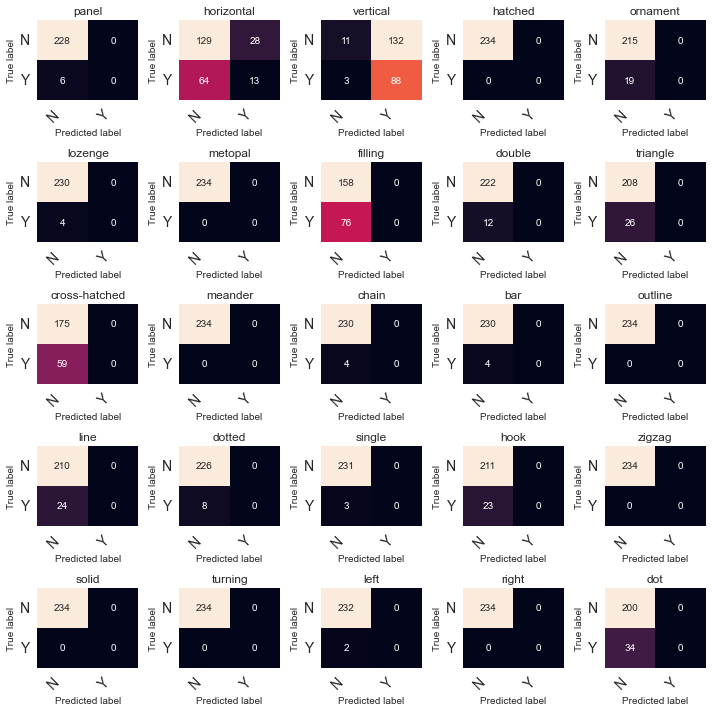

<Figure size 432x288 with 0 Axes>

In [100]:
# def plot_multiple_matrix(cfs_matrix, present_labels, nrows=5, ncols=5, figsize=(6,10), filename="results"):
plot_multiple_matrix(cfs_matrix, present_labels, figsize=(10, 10))

# Binary Relevance with handcrafted class balance

In [101]:
def split_balanced(label, columns, X_train, Y_train):
  """Generates a balanced train and test dataset for a given label
    ATTENTION: MODIFIED TO ADD ONLY ORIGINAL PATTERNS TO THE NEGATIVE DATASET

    Parameters:
    label (String): label with which the balanced dataset will be created
    colnames (1D array):
    X_train, Y_train (dataFrames): original (potentially unbalanced) train datasets.

    Returns:
    X_train, Y_train (dataFrames): train datasets with equal number of positive and
                                  negative events for the given label. 

  """
  index_label = columns.tolist().index(label)
  indexes_positives = []
  indexes_negatives = []

  i=0
  for index, row in Y_train.iterrows():
    if row.values[index_label] == 1:
      indexes_positives.append(i)
    elif "_" not in index:
      indexes_negatives.append(i)
    i+=1
  indexes_negatives = indexes_negatives[0:len(indexes_positives)]
  final_indexes = indexes_positives + indexes_negatives
  final_indexes.sort()
  X_train = X_train.values[final_indexes, :]
  Y_train = Y_train.values[final_indexes, index_label]
  return X_train, Y_train

In [108]:
base_classifiers = {}
THRESHOLD = 105
top_labels, _ = filter_labels(labels_train, THRESHOLD)
print("ATTENTION: TESTING WITH {} LABELS".format(len(top_labels)))
X_train = features_train
Y_train = filter_dfs(labels_train, top_labels)
X_test = features_test
Y_test = filter_dfs(labels_test, top_labels)
columns = Y_test.columns
predictions = []

for i in range(0, len(top_labels)):
  label = columns[i]
  bc = LogisticRegression(solver='lbfgs')
  X_train_label, Y_train_label = split_balanced(label, columns, X_train, Y_train) # tantos positivos como posible e igual a negativos
  bc.fit(X_train_label, Y_train_label)
  base_classifiers[label] = bc
  clf_prediction = bc.predict(X_test.values)
  predictions.append(clf_prediction) # una columna de prediccion

predictions = np.array(predictions).T

exact_match = accuracy_score(Y_test.values, predictions)
ham_loss = hamming_loss(Y_test.values, predictions)
ham_score = hamming_score(Y_test.values, predictions)

#print("Exact match ratio: {}".format(exact_match))
#print("Hamming loss: {}".format(ham_loss))
print("Hamming score: {}".format(ham_score))

ATTENTION: TESTING WITH 25 LABELS
Hamming score: 0.09173183436511533


In [109]:
present_labels = top_labels.index
cfs_matrix = multilabel_confusion_matrix(Y_test, predictions)
class_report = classification_report(Y_test,
                                      predictions,
                                      output_dict=False,
                                      target_names=present_labels)
print(class_report)

               precision    recall  f1-score   support

        panel       0.31      0.92      0.46        48
   horizontal       0.38      0.97      0.54        59
     vertical       0.08      0.36      0.13        14
      hatched       0.01      1.00      0.02         1
     ornament       0.04      0.67      0.08         6
      lozenge       0.12      0.60      0.20        15
      metopal       0.18      0.31      0.22        36
      filling       0.08      0.38      0.14        16
     triangle       0.00      0.00      0.00         0
       double       0.00      0.00      0.00         0
cross-hatched       0.17      0.38      0.23        32
      meander       0.01      0.25      0.02         4
        chain       0.10      0.59      0.16        17
          bar       0.09      0.70      0.16        10
      outline       0.00      0.00      0.00         0
         line       0.04      0.80      0.07         5
       single       0.03      0.38      0.05         8
         

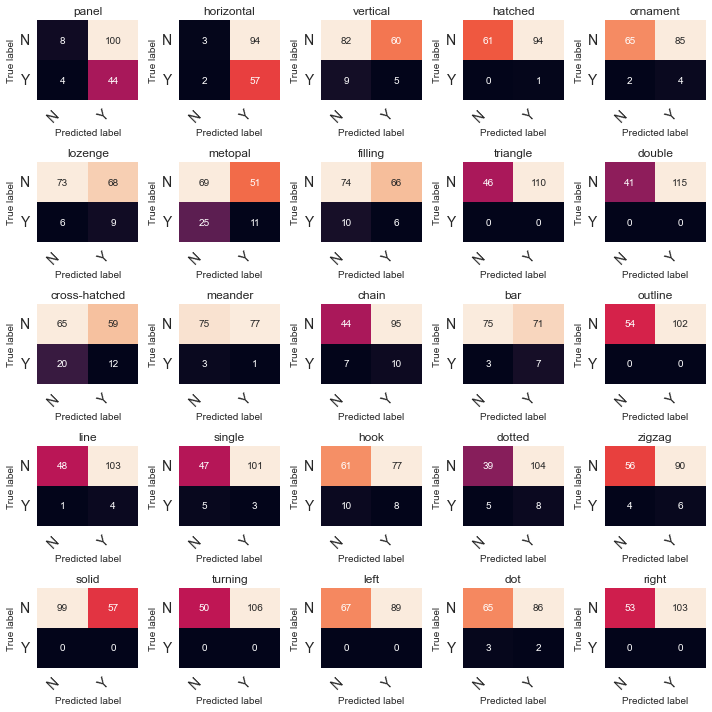

<Figure size 432x288 with 0 Axes>

In [110]:
plot_multiple_matrix(cfs_matrix, present_labels,  figsize=(10, 10))